# Experiments with GloVE embeddings

To get data:

1. Run `python scripts/download_glove.py`
2. Wait for it...
3. Proceed.

In [1]:
import graph_structure as gs
import numpy as np
from tqdm import tqdm
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.metrics import pairwise_distances
import pandas as pd
import re

In [2]:
def cka(X1, X2):
    # Center the data
    X1 = X1 - X1.mean(axis=0)
    X2 = X2 - X2.mean(axis=0)

    # Compute the kernel matrices
    K1 = X1.T @ X1
    K2 = X2.T @ X2

    # Compute the squared Frobenius norms
    norm1 = np.linalg.norm(K1, 'fro')
    norm2 = np.linalg.norm(K2, 'fro')

    # Compute the CKA
    cka = np.linalg.norm(X2.T @ X1, 'fro')**2 / (norm1 * norm2)
    return cka



## Reading data files

In [3]:
with open('../data/questions-words.txt', 'r') as f:
    data = f.read()
print(len(data))

603955


In [4]:
# Reading analogies
titles = re.findall(':.*\n', data)
contents = re.split(':.*\n', data)

metaphors = {}
for idx, s in enumerate(titles):
    title = s.replace('\n', '').replace(': ', '').rstrip().lstrip()
    lines = contents[idx+1].split('\n')
    g1 = []
    g2 = []
    for line in lines:
        if len(line) < 5:
            continue
        #print(line)
        a, b, c, d = line.split(' ')
        if (a not in g1) and (b not in g2):
            g1.append(a)
            g2.append(b)
        if (c not in g1) and (d not in g2):
            g1.append(c)
            g2.append(d)
    metaphors[title] = [g1, g2]

In [5]:
# Load GloVe embeddings
fname = 'glove.6B.300d.txt'
def load_glove(fname):
    embed_dict = {}
    with open('../data/' + fname,'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:],'float32')
            embed_dict[word]=vector
    return embed_dict

In [6]:
def embedding_space(word_list, embed_dict):
    x = [embed_dict[w.lower()] for w in word_list]
    x = np.array(x)
    return x

In [14]:
def topology_experiment(metaphors, embed_dict):
    results = {}
    for category in metaphors.keys():
        g1 = metaphors[category][0]
        g2 = metaphors[category][1]
        e1 = embedding_space(g1, embed_dict)
        e2 = embedding_space(g2, embed_dict)
        a = gs.cka(e1, e2)
        results[category] = (a, len(g1))
    return results

## Topology vs. K


In [15]:
embed_dict = load_glove(fname)
print("Loaded")


Loaded


In [16]:
sg = {}

for category in tqdm(metaphors.keys()):
    sg[category] = []
    g1 = np.array(metaphors[category][0])
    g2 = np.array(metaphors[category][1])
    

    #print(choices, n_bootstrap,e1.shape, len(g1))
    e1 = embedding_space(g1, embed_dict)
    e2 = embedding_space(g2, embed_dict)
    
    ks = list(range(1, len(e1)))        
    for idx, k in enumerate(ks):
        s = cka(e1, e2)
        sg[category].append(s)
    
    sg[category] = np.array(sg[category])
    

100%|██████████| 14/14 [00:00<00:00, 35.15it/s]


In [17]:

def analogy_experiment(metaphors, embed_dict):
    results = {}
    for category in metaphors.keys():
        g1 = metaphors[category][0]
        g2 = metaphors[category][1]
        e1 = embedding_space(g1, embed_dict)
        e2 = embedding_space(g2, embed_dict)

        acc = 0
        tries = 0        
        for i in range(len(g1)):
            for j in range(i+1, len(g1)):
                tries += 1
                w = e1[i,:] - e2[i,:] + e1[j,:]
                w = w.reshape( (1,-1))
                p = pairwise_distances(w, e2, metric='cosine')
                if np.argmin(p)==j:
                    acc += 1
        
        results[category] = (acc/tries, len(g1))
    return results

In [18]:
res = topology_experiment(metaphors, embed_dict)
res2 = analogy_experiment(metaphors, embed_dict)

In [19]:
results = np.array([ [res[k][0], res2[k][0]] for k in res.keys()])
labels = list(res.keys())
st.pearsonr(results[:,0],results[:,1])
st.spearmanr(results[:,0],results[:,1])

SignificanceResult(statistic=0.7406593406593407, pvalue=0.002445197640446019)

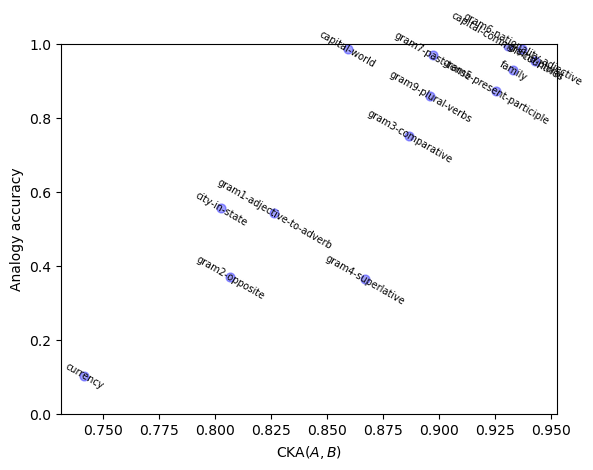

In [20]:
plt.figure()
for j in range(4):
    if j == 1 or j ==2 or j==1:
        continue
    plt.scatter(results[:,0], results[:,1], c='b', s=40, alpha=0.2)

plt.xlabel('CKA$(A,B)$')
plt.ylabel('Analogy accuracy')
plt.ylim([0,1])
#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
for idx, text in enumerate(labels):
    plt.text(results[idx,0], results[idx,1], s=text, fontsize=7, ha='center', va='center', rotation=-30)
#plt.title('GLoVe embeddings and Structural distance')
plt.savefig('glove_accuracy_similarity_cka.pdf', bbox_inches='tight')
plt.show()